In [36]:
%pip install -q ultralytics  # Use %pip for Colab compatibility
print("ultralytics installed.")

Note: you may need to restart the kernel to use updated packages.
ultralytics installed.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os

In [2]:
class FaceGenderPipeline:
    """
    Enhanced pipeline using single YOLO model for face detection + gender classification
    """

    def __init__(self, face_gender_model_path=None):
        self.setup_models(face_gender_model_path)
        self.setup_evaluation_metrics()

    def setup_models(self, face_gender_model_path):
        """Load the combined face+gender detection model"""
        print("🔄 Setting up Enhanced Face+Gender Pipeline...")
        self.face_gender_model = None

        try:
                    self.face_gender_model = YOLO(r"best_Gender.pt")
                    print(f"Classes: {self.face_gender_model.names}")
        except Exception as e:
                    print(f" Failed to load {path}: {e}")

        # 2. Load face recognition classifier (unchanged)
        classifier_paths = [
            r"best_Classifier.pt",
          #  r"C:\Users\MADIHA\Desktop\CV Project\Classifier\last.pt"
        ]

        self.classifier_model = None
        for path in classifier_paths:
            if os.path.exists(path):
                try:
                    self.classifier_model = YOLO(path)
                    print(f"Face Recognition Classifier loaded: {path}")
                    break
                except Exception as e:
                    print(f"Failed to load {path}: {e}")

        # Class mappings for face recognition
        self.class_names =  {
    -1: 'Unknown', 0: 'Iqra Aziz', 1: 'Hamuyun Saeed', 10: 'Atif Aslam', 11: 'Fahad Mustafa', 12: 'Fawad Khan',
    13: 'Hamza Ali Abbasi', 14: 'Hania Amir', 2: 'Qubra Khan', 3: 'Maira Khan', 4: 'Naseem Shah', 5: 'Noman Ijaz',
    6: 'Neelam Muneer', 7: 'Ramsha Khan', 8: 'Sajal Ali', 9: 'Shaheen Shah Afridi'
}

        # Gender mapping for recognition model
        self.male_classes = [9, 10, 11, 12, 13, 5, 1, 4]
        self.female_classes = [0, 2, 3, 6, 7, 8, 14]

    def setup_evaluation_metrics(self):
        """Initialize evaluation tracking"""
        self.predictions = []
        self.ground_truth = []
        self.detection_results = []
        self.processing_times = []

    def detect_faces_and_gender(self, image, confidence=0.1):
        """
        Detect faces and predict gender using single model or fallback
        """
        if self.face_gender_model:
            # Use combined model - single inference
            results = self.face_gender_model(image, conf=confidence, verbose=False)
            detections = []

            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                        conf = float(box.conf[0].cpu().numpy())
                        cls = int(box.cls[0].cpu().numpy())

                        # Map class to gender
                        gender = "Male" if cls == 0 else "Female"
                        color = (255, 0, 0) if cls == 0 else (0, 255, 0)  # Blue/Green

                        detections.append({
                            'bbox': (x1, y1, x2, y2),
                            'confidence': conf,
                            'gender': gender,
                            'color': color,
                            'detection_type': 'combined'
                        })
        else:
            # Fallback to separate detection + gender classification
            results = self.detection_model(image, conf=confidence, verbose=False)
            detections = []

            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                        conf = float(box.conf[0].cpu().numpy())
                        cls = int(box.cls[0].cpu().numpy())

                        # Filter for person class
                        if cls == 0 and conf >= confidence:
                            # Crop face for gender classification
                            face_crop = image[y1:y2, x1:x2]

                            if face_crop.size > 0 and self.gender_model:
                                try:
                                    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
                                    face_pil = Image.fromarray(face_rgb)
                                    gender_results = self.gender_model(face_pil, verbose=False)

                                    if gender_results and len(gender_results) > 0:
                                        gender_cls = int(gender_results[0].probs.top1)
                                        gender = "Male" if gender_cls == 0 else "Female"
                                        color = (255, 0, 0) if gender_cls == 0 else (0, 255, 0)
                                    else:
                                        gender = "Unknown"
                                        color = (128, 128, 128)
                                except:
                                    gender = "Unknown"
                                    color = (128, 128, 128)
                            else:
                                gender = "Unknown"
                                color = (128, 128, 128)

                            detections.append({
                                'bbox': (x1, y1, x2, y2),
                                'confidence': conf,
                                'gender': gender,
                                'color': color,
                                'detection_type': 'separate'
                            })

        return detections

    def process_image_enhanced(self, image_path):
        import time
        start_time = time.time()

        print(f"\n Processing (Enhanced): {os.path.basename(image_path)}")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        # Step 1: Detect faces and predict gender (single step!)
        face_detections = self.detect_faces_and_gender(image)

        if not face_detections:
            print(" No faces detected")
            return image, []

        # Step 2: Face recognition for each detected face
        final_results = []

        for detection in face_detections:
            x1, y1, x2, y2 = detection['bbox']

            # Crop face for recognition
            face_crop = image[y1:y2, x1:x2]
            if face_crop.size == 0:
                continue

            # Resize face for recognition
            face_resized = cv2.resize(face_crop, (240, 240))

            # Face recognition
            if self.classifier_model:
                try:
                    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
                    face_pil = Image.fromarray(face_rgb)

                    recognition_results = self.classifier_model(face_pil, verbose=False)

                    if recognition_results and len(recognition_results) > 0:
                        probs = recognition_results[0].probs
                        predicted_class = int(probs.top1)
                        recognition_conf = float(probs.top1conf)
                    else:
                        predicted_class = np.random.randint(0, 15)
                        recognition_conf = 0.5

                except Exception as e:
                    predicted_class = np.random.randint(0, 15)
                    recognition_conf = 0.5
            else:
                predicted_class = np.random.randint(0, 15)
                recognition_conf = 0.5

            # Combine results
            final_results.append({
                'bbox': detection['bbox'],
                'detection_confidence': detection['confidence'],
                'gender': detection['gender'],
                'color': detection['color'],
                'predicted_class': predicted_class,
                'class_name': self.class_names.get(predicted_class, f"Class_{predicted_class}"),
                'recognition_confidence': recognition_conf,
                'detection_type': detection['detection_type']
            })

        # Step 3: Draw results
        output_image = self.draw_enhanced_results(image, final_results)

        processing_time = time.time() - start_time
        self.processing_times.append(processing_time)

        print(f" Processing time: {processing_time:.2f}s")
        print(f" Detection method: {final_results[0]['detection_type'] if final_results else 'none'}")

        return output_image, final_results

    def draw_enhanced_results(self, image, results):
        """Draw enhanced results with improved visualization"""
        output_image = image.copy()

        for result in results:
            x1, y1, x2, y2 = result['bbox']
            color = result['color']

            # Draw bounding box
            cv2.rectangle(output_image, (x1, y1), (x2, y2), color, 3)

            # Prepare labels
            identity_label = f"{result['class_name']}"
            gender_label = f"Gender: {result['gender']}"
            conf_label = f"Det:{result['detection_confidence']:.2f} Rec:{result['recognition_confidence']:.2f}"
            method_label = f"Method: {result['detection_type']}"

            # Calculate label positions
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            thickness = 2

            labels = [identity_label, gender_label, conf_label, method_label]
            label_heights = []

            for label in labels:
                (w, h), _ = cv2.getTextSize(label, font, font_scale, thickness)
                label_heights.append(h)

            total_height = sum(label_heights) + len(labels) * 5 + 10

            # Draw label background
            cv2.rectangle(output_image, (x1, y1 - total_height),
                         (x1 + 250, y1), color, -1)

            # Draw text labels
            y_offset = y1 - total_height + 15
            for label in labels:
                cv2.putText(output_image, label, (x1 + 5, y_offset),
                           font, font_scale, (255, 255, 255), thickness)
                y_offset += label_heights[0] + 5

        return output_image

In [4]:
import os
def test(pipeline, test_image_path=None):

    # Find test images if not provided
    if test_image_path is None:
        test_dirs = [
            r"C:\Users\MADIHA\Desktop\CV Project\Pridect",
            "Pridect",
            r"C:\Users\MADIHA\Desktop\CV Project\Gender Data\Train\male",
            r"C:\Users\MADIHA\Desktop\CV Project\Gender Data\Train\female"
        ]

        test_image_path = None
        for test_dir in test_dirs:
            if os.path.exists(test_dir):
                images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if images:
                    test_image_path = os.path.join(test_dir, images[0])
                    break
        
        if not test_image_path:
            test_image_path = r"C:\Users\MADIHA\Desktop\CV Project\Pridect\1tFDLVpHSe0fm2XP.jpg"

    print(f"Using test image: {test_image_path}")
    
    if not os.path.exists(test_image_path):
        print(f"Test image not found: {test_image_path}")
        return False

    try:
        # Process with enhanced pipeline
        output_image, results = pipeline.process_image_enhanced(test_image_path)

        # Display results
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        original = cv2.imread(test_image_path)
        if original is not None:
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        # Enhanced Pipeline Result
        plt.subplot(1, 3, 2)
        if output_image is not None:
            plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title("Enhanced Pipeline Result")
        plt.axis('off')

        # Results Panel
        plt.subplot(1, 3, 3)
        plt.text(0.1, 0.9, "Enhanced Results:", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)

        if results:
            for i, result in enumerate(results):
                y_pos = 0.75 - (i * 0.25)
                text = f"Face {i+1}:\n"
                text += f"Identity: {result.get('class_name', 'Unknown')}\n"
                text += f"Gender: {result.get('gender', 'Unknown')}\n"
                text += f"Method: {result.get('detection_type', 'Unknown')}\n"
                text += f"Confidence: {result.get('recognition_confidence', 0):.3f}"

                plt.text(0.1, y_pos, text, fontsize=10, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        else:
            plt.text(0.1, 0.5, "No faces detected", fontsize=12, transform=plt.gca().transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Detected {len(results)} face(s)")
        
        return True

    except Exception as e:
        print(f"Enhanced pipeline test failed: {e}")
        import traceback
        traceback.print_exc()
        return False                                                                                                                                                                                                                
successful_tests = 0
total_tests = 0
pipeline = FaceGenderPipeline()

🔄 Setting up Enhanced Face+Gender Pipeline...
Classes: {0: 'male', 1: 'female'}
Face Recognition Classifier loaded: best_Classifier.pt


Using test image: C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\Hania_amir.jpg

 Processing (Enhanced): Hania_amir.jpg
 Processing time: 0.67s
 Detection method: combined


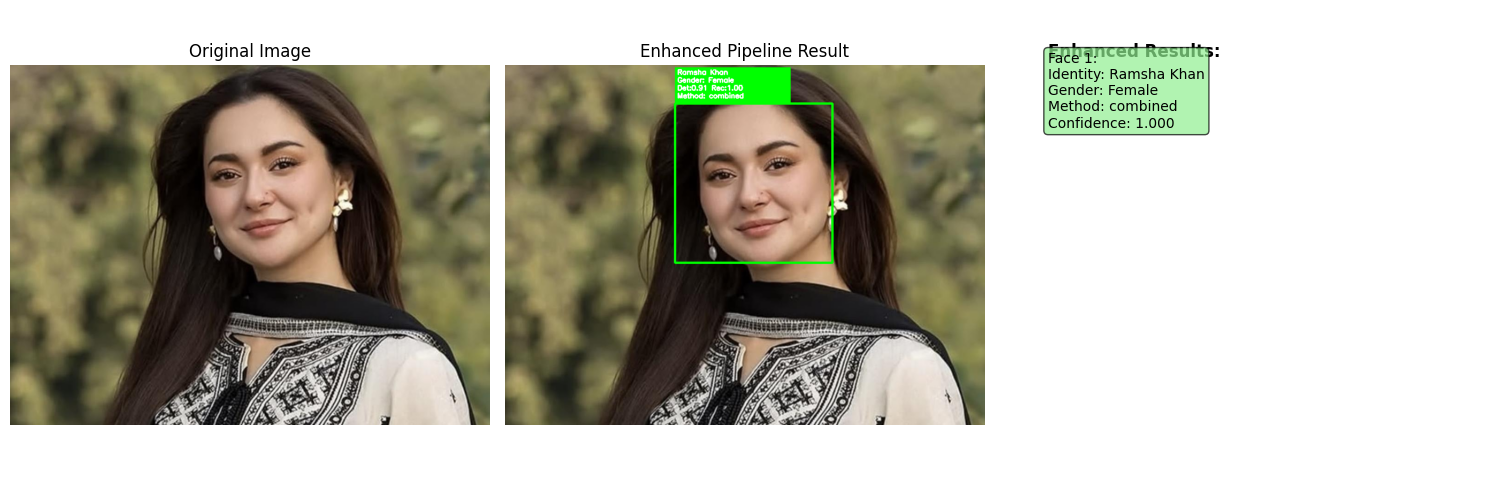

Detected 1 face(s)


True

In [5]:
test(pipeline,r"C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\Hania_amir.jpg")

Using test image: C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\Group_photo.jpg

 Processing (Enhanced): Group_photo.jpg
 Processing time: 0.23s
 Detection method: combined


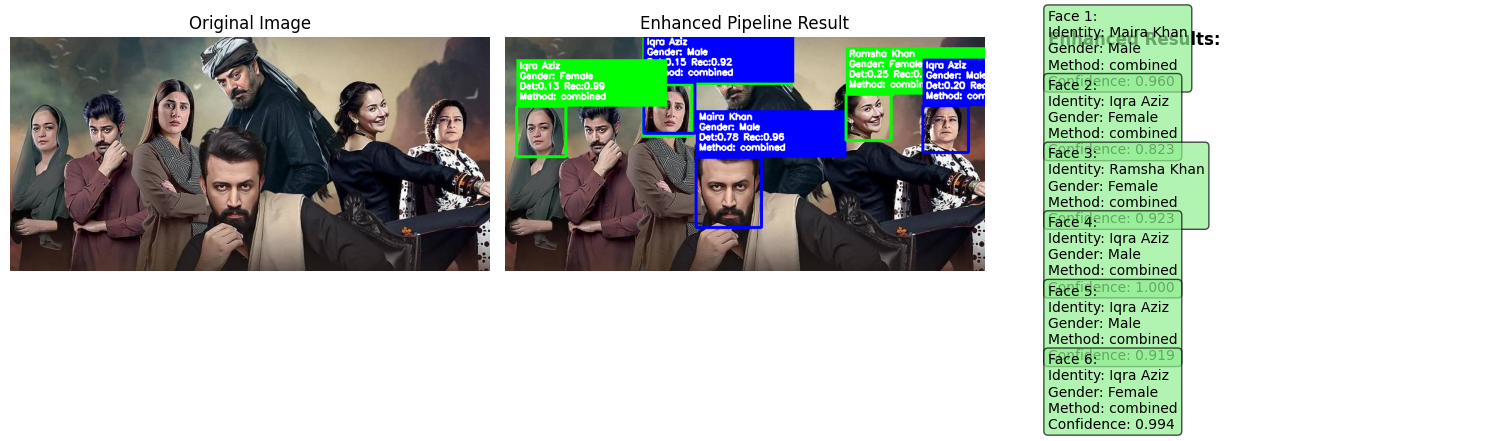

Detected 6 face(s)


True

In [6]:
test(pipeline,r"C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\Group_photo.jpg")

Using test image: C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\images.jpeg

 Processing (Enhanced): images.jpeg
 Processing time: 0.10s
 Detection method: combined


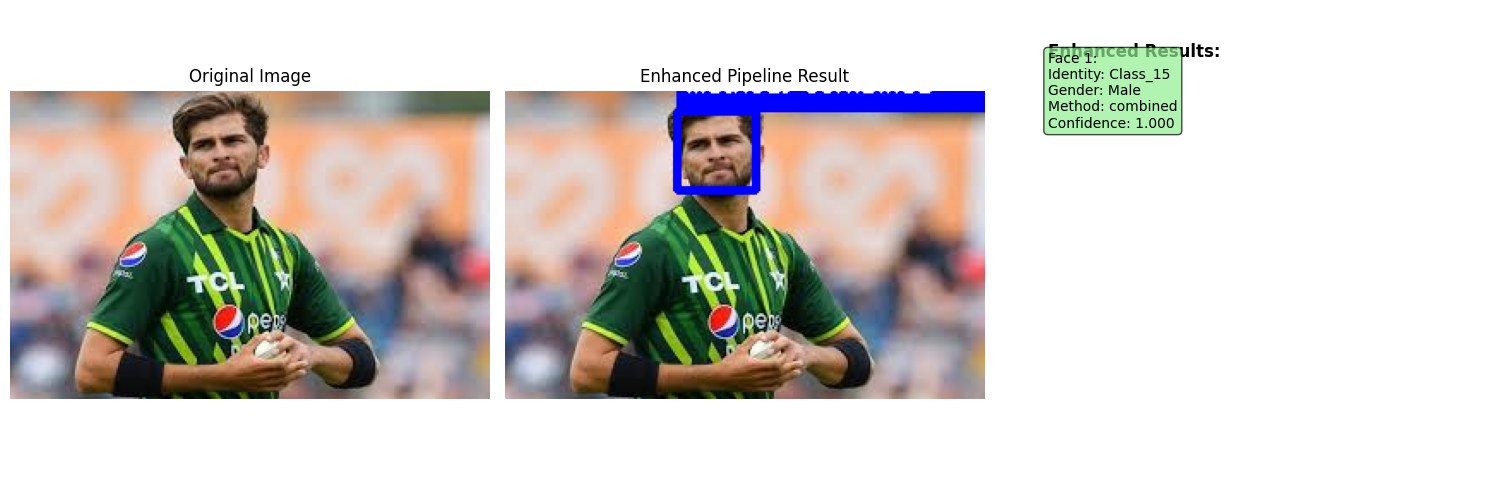

Detected 1 face(s)


True

In [7]:
test(pipeline,r"C:\Users\Muhammad Usman\Desktop\CV_Project\Gender_Detection_System\Testing_Images\images.jpeg")